In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter

from warnings import filterwarnings
filterwarnings("ignore")
from termcolor import colored

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

import string 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Input,
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from transformers import TFBertModel

In [2]:
import h5py
from keras.models import load_model

try:
    import h5py
    print ('import fine')
except ImportError:
    h5py = None


import fine


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [4]:
train_data=pd.read_csv("./Corona_NLP_train.csv",encoding="latin1")
test_data=pd.read_csv("./Corona_NLP_test.csv",encoding="latin1")

In [5]:
train_data.shape

(41157, 6)

In [6]:
train_data.drop_duplicates()
train_data.shape

(41157, 6)

In [7]:
train_data.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
train_data.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [9]:
df_ita = train_data[train_data['Location'] == "Italy"]
len(df_ita)

14

In [10]:
df = train_data
df_t = test_data 
df.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [11]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")
counts

Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
Name: Sentiment, dtype: int64

In [12]:
balance_counts = counts.values

fig = go.Figure()
for i in range(len(balance_counts)):
    fig.add_trace(go.Bar(
        x=[counts.index[i]],
        y=[balance_counts[i]],
        name=counts.index[i],
        text=[balance_counts[i]],
        textposition='auto',
        marker_color="blue"
    ))
fig.show()

In [13]:
# training set, remove neutral tweets and aggregate positive and negative
new_sent = df["Sentiment"].copy()
for i in range(len(df["Sentiment"])): 
    if (df["Sentiment"][i] == "Extremely Positive"):
        new_sent[i] = "Positive"
    elif (df["Sentiment"][i] == "Extremely Negative"):
        new_sent[i] = "Negative"
        
df["target"] = new_sent
df.drop(df[df["target"] == "Neutral"].index, inplace = True)

In [14]:
# test set, remove neutral tweets and aggregate positive and negative
new_sent = df_t["Sentiment"].copy()
for i in range(len(df_t["Sentiment"])): 
    if (df_t["Sentiment"][i] == "Extremely Positive"):
        new_sent[i] = "Positive"
    elif (df_t["Sentiment"][i] == "Extremely Negative"):
        new_sent[i] = "Negative"
        
df_t["target"] = new_sent
df_t.drop(df_t[df_t["target"] == "Neutral"].index, inplace = True)

In [15]:
counts = df.groupby("target")["target"].agg("count")
balance_counts = counts.values

fig = go.Figure()
for i in range(len(balance_counts)):
    fig.add_trace(go.Bar(
        x=[counts.index[i]],
        y=[balance_counts[i]],
        name=counts.index[i],
        text=[balance_counts[i]],
        textposition='auto',
        marker_color="blue"
    ))
fig.show()

In [16]:
# remove punctuation
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
# remove stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    

In [18]:
# stemming (remove end of words)
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text


In [19]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [20]:
df['tweet_clean'] = df['OriginalTweet'].apply(preprocess_data)
df_t['tweet_clean'] = df_t['OriginalTweet'].apply(preprocess_data)

df.head()

UserName  ScreenName                   Location     TweetAt  \
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   

                                       OriginalTweet           Sentiment  \
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   

     target                                        tweet_clean  
1  Positive  advic talk neighbour famili exchang phone numb...  
2  Positive  coronavirus australia woolworth give elder dis...  
3  Positive  food stock one empty\r\r\r\rpleas dont panic e...  
4  Negative  readi go supermarket  outbreak\r\r\r\rnot para...  
5  Positive  news regionâ first confirm  case came sulliva...

In [21]:
# target encoding train
le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

UserName  ScreenName                   Location     TweetAt  \
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   

                                       OriginalTweet           Sentiment  \
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   
5  As news of the regionÂs first confirmed COVID...            Positive   

     target                                        tweet_clean  target_encoded  
1  Positive  advic talk neighbour famili exchang phone numb...               1  
2  Positive  coronavirus australia woolworth give elder dis...               1  
3  Positive  food stock one empty\r\r\r\rpleas dont panic e...               1  
4  Negative  readi go supermarket  outbreak\r\r\r\rnot para...               0  
5  Positive  news regionâ first confirm  case came sulliva...               1

In [22]:
# target encoding test
le = LabelEncoder()
le.fit(df_t['target'])

df_t['target_encoded'] = le.transform(df_t['target'])

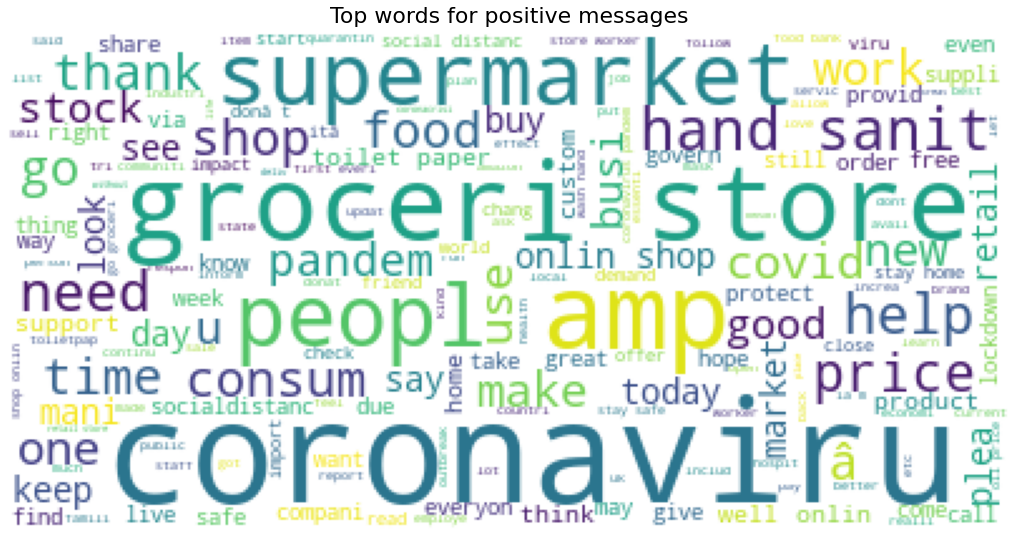

In [28]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[(df['target'] == 'Positive'), 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for positive messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

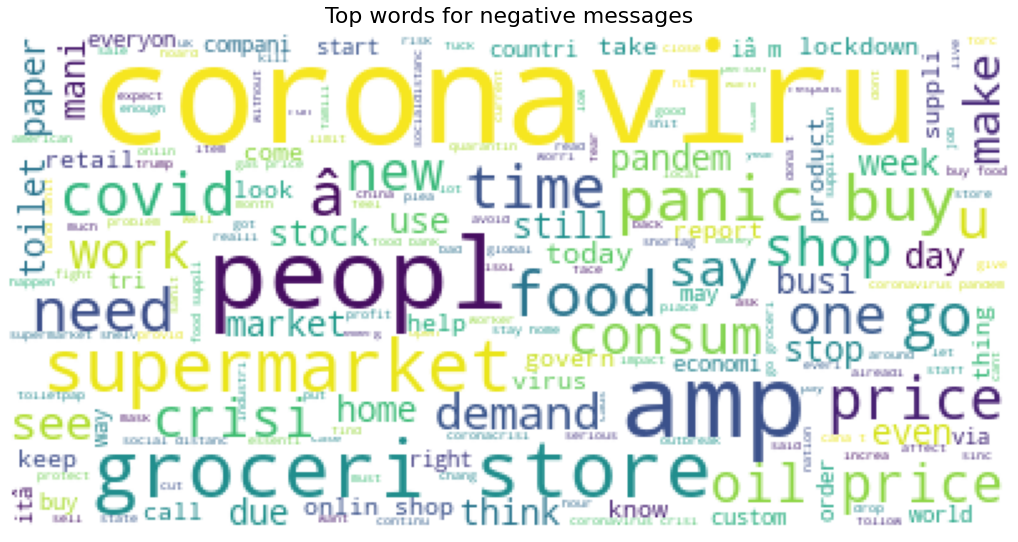

In [29]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[(df['target'] == 'Negative'), 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for negative messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Tf-idf

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus.


In [30]:
# split into train & test set
x_train, x_test, y_train, y_test = df['tweet_clean'], df_t['tweet_clean'], df['target_encoded'], df_t['target_encoded']
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

33444 33444
3179 3179


In [31]:
# convert texts into a matrix of token counts (sparse matrix with dim nr tweets, nr words)
# do not consider stopwords, include bigrams as features, pick only words that have certain frequency, pick the first 100 words
vect = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect.fit(x_train)

x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)
print(pd.DataFrame(x_train_dtm.toarray(), columns = vect.get_feature_names()))

       consum  coronavirus  food  groceri  groceri store  peopl  price  shop  \
0           0            0     0        0              0      0      0     1   
1           0            1     0        0              0      0      0     1   
2           0            1     2        0              0      0      0     0   
3           0            1     1        0              0      0      0     0   
4           0            0     1        0              0      1      0     0   
...       ...          ...   ...      ...            ...    ...    ...   ...   
33439       0            1     0        0              0      0      0     0   
33440       0            0     0        1              1      1      0     0   
33441       1            0     0        0              0      0      0     0   
33442       0            1     0        0              0      0      0     0   
33443       0            0     0        0              0      0      2     0   

       store  supermarket  
0          

In [32]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

print(pd.DataFrame(x_train_tfidf.toarray(), columns = vect.get_feature_names()))
print(x_train_tfidf.shape)

       consum  coronavirus      food   groceri  groceri store     peopl  \
0         0.0     0.000000  0.000000  0.000000        0.00000  0.000000   
1         0.0     0.508956  0.000000  0.000000        0.00000  0.000000   
2         0.0     0.322217  0.946666  0.000000        0.00000  0.000000   
3         0.0     0.438661  0.644387  0.000000        0.00000  0.000000   
4         0.0     0.000000  0.564383  0.000000        0.00000  0.614940   
...       ...          ...       ...       ...            ...       ...   
33439     0.0     0.573639  0.000000  0.000000        0.00000  0.000000   
33440     0.0     0.000000  0.000000  0.488579        0.52811  0.517378   
33441     1.0     0.000000  0.000000  0.000000        0.00000  0.000000   
33442     0.0     1.000000  0.000000  0.000000        0.00000  0.000000   
33443     0.0     0.000000  0.000000  0.000000        0.00000  0.000000   

       price      shop     store  supermarket  
0        0.0  1.000000  0.000000     0.000000  
1  

# Multinomial naive bayes model 
Probabilistic classifier with independence assumption between fetures

In [33]:
# Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [34]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.5438817238125196


In [35]:
x_axes = ['Negative', 'Positive']
y_axes =  ['Positive', 'Negative']
def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig


m = metrics.confusion_matrix(y_test, y_pred_class)
conf_matrix(m)

# XGBoost

XGBoost is a regularized gradient boosting framework, i.e. a prediction model in the form of an ensemble of weak prediction models, typically decision trees. When the weak learners are added, they are weighted in a way that is related to the their accuracy. Thus, future weak learners focus more on the examples that previous weak learners misclassified.

In [36]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [37]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: 0.8088446358091137
Test: 0.7499213589178987


In [38]:
m = metrics.confusion_matrix(y_test, y_pred_class)
conf_matrix(m)

# GLOVE + LSTM

Glove embedding is a representation of words in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture which can process sequences of data.
A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. LSTM networks are well-suited to classifying, processing and making predictions based on time series data.



In [40]:
train_tweets = df['tweet_clean'].values
test_tweets = df_t['tweet_clean'].values
train_target = df["target_encoded"]
test_target = df_t["target_encoded"]

In [41]:
# length of vocabulary 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

51725

In [42]:
# pad sequences
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train)) # compute length of longest sentence

# transofrm list in 2d numpy array (num samples, length longest sentence)
train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[  502,   351,  1420, ...,     0,     0,     0],
       [    1,   788,  1566, ...,     0,     0,     0],
       [    4,    28,    31, ...,     0,     0,     0],
       ...,
       [  147,   845,   136, ...,     0,     0,     0],
       [   61,   143,    12, ...,     0,     0,     0],
       [51721,   118, 51722, ...,     0,     0,     0]])

In [43]:
embeddings_dictionary = dict()

# Load GloVe 100D embeddings & store it in a dictionary
with open("./glove.6B.100d.txt", encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
        

In [44]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_length, embedding_dim))

# load embeddings of the words from the glove dictionary
# initialize words not in the dictionary to 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.052436  ,  0.55505002,  0.29279   , ..., -0.88300002,
         0.36973   , -1.0467    ],
       [ 0.33107999,  0.19363999,  0.16607   , ..., -0.33899   ,
         0.59354001, -0.016754  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18133999,  0.26045999,  0.71123999, ..., -0.42002001,
         0.33447   ,  0.45105001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
# redefine samples 
X_train, X_test = train_padded_sentences, test_padded_sentences

In [46]:
# define model (glove lstm)
model = Sequential()
    
model.add(Embedding(
    input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_matrix.shape[1], 
    weights = [embedding_matrix], 
    input_length=length_long_sentence
))

model.add(Bidirectional(LSTM(
    length_long_sentence, 
    return_sequences = True, 
    recurrent_dropout=0.2
)))

model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 100)           5172500   
_________________________________________________________________
bidirectional (Bidirectional (None, 43, 86)            49536     
_________________________________________________________________
global_max_pooling1d (Global (None, 86)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 86)                344       
_________________________________________________________________
dropout (Dropout)            (None, 86)                0         
_________________________________________________________________
dense (Dense)                (None, 43)                3741      
_________________________________________________________________
dropout_1 (Dropout)          (None, 43)                0

In [47]:
# train lstm
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
1046/1046 [==============================] - 159s 85ms/step - loss: 0.7593 - accuracy: 0.5813 - val_loss: 0.4798 - val_accuracy: 0.7701

Epoch 00001: val_loss improved from inf to 0.47983, saving model to model.h5
Epoch 2/7
1046/1046 [==============================] - 81s 78ms/step - loss: 0.4521 - accuracy: 0.8057 - val_loss: 0.3926 - val_accuracy: 0.8201

Epoch 00002: val_loss improved from 0.47983 to 0.39257, saving model to model.h5
Epoch 3/7
1046/1046 [==============================] - 83s 79ms/step - loss: 0.3538 - accuracy: 0.8584 - val_loss: 0.3831 - val_accuracy: 0.8286

Epoch 00003: val_loss improved from 0.39257 to 0.38313, saving model to model.h5
Epoch 4/7
1046/1046 [==============================] - 82s 78ms/step - loss: 0.3093 - accuracy: 0.8837 - val_loss: 0.4162 - val_accuracy: 0.8226

Epoch 00004: val_loss did not improve from 0.38313
Epoch 5/7
1046/1046 [==============================] - 84s 80ms/step - loss: 0.2697 - accuracy: 0.9055 - val_loss: 0.4839 - v

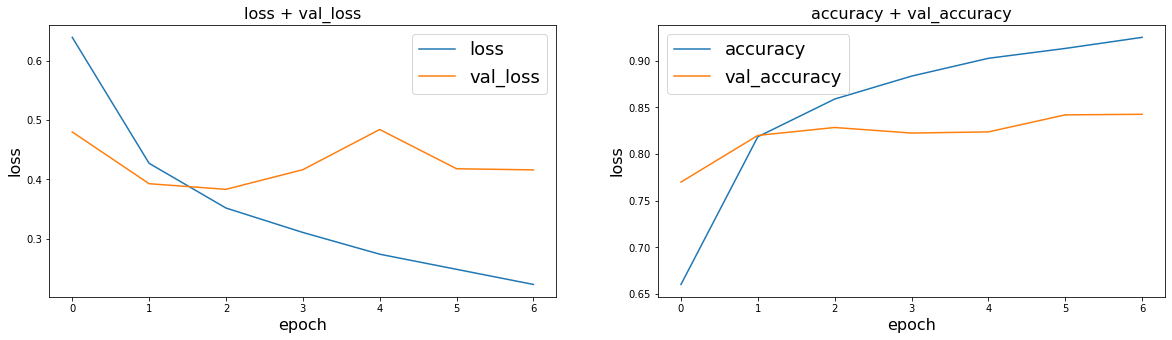

In [48]:
arr = [['loss', 'val_loss'],['accuracy', 'val_accuracy']]


fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for idx in range(2):
    ax[idx].plot(history.history[arr[idx][0]])
    ax[idx].plot(history.history[arr[idx][1]])
    ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
    ax[idx].set_xlabel('epoch',fontsize=16)
    ax[idx].set_ylabel('loss',fontsize=16)
    ax[idx].set_title(arr[idx][0] + ' + ' + arr[idx][1],fontsize=16)

In [49]:
# predictions
preds = model.predict_classes(X_test)

# BERT

A transformer is a deep learning model that adopts the mechanism of attention, differentially weighting the significance of each part of the input data. Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, although they do not necessarily process the data in order. Rather, the attention mechanism helps identify the context that confers meaning to each word in the sentence. This feature allows for more parallelization than RNNs and therefore reduces training times.

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained  transformer-based system trained with a large language dataset by Google.

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [24]:
def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [25]:
texts = df['tweet_clean']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [26]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [27]:
# bert model
input_ids = tf.keras.Input(shape=(60,),dtype='int32')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

output = bert_model([input_ids,attention_masks])
output = output[1]
output = tf.keras.layers.Dense(32,activation='relu')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
_______________________________________________________

In [28]:
# fit model
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
2676/2676 [==============================] - 11656s 4s/step - loss: 0.4454 - accuracy: 0.7889 - val_loss: 0.3181 - val_accuracy: 0.8649
Epoch 2/3
2676/2676 [==============================] - 8164s 3s/step - loss: 0.2941 - accuracy: 0.8832 - val_loss: 0.3143 - val_accuracy: 0.8707
Epoch 3/3
2676/2676 [==============================] - 11317s 4s/step - loss: 0.2122 - accuracy: 0.9204 - val_loss: 0.3151 - val_accuracy: 0.8764


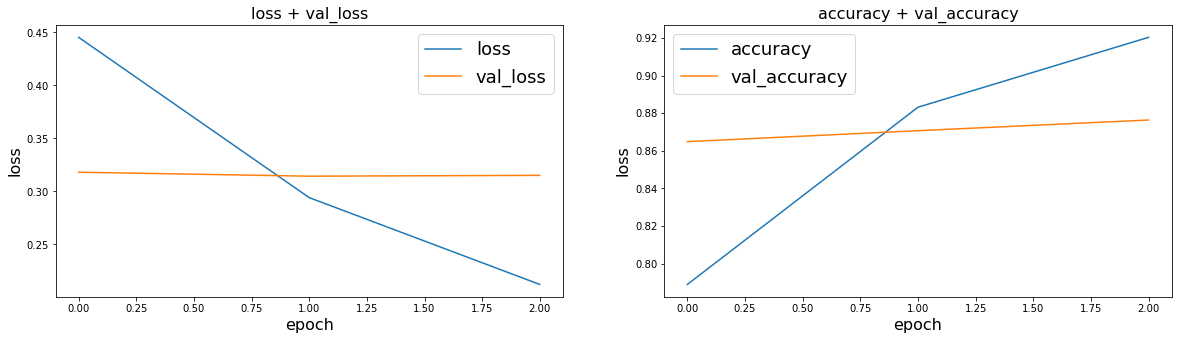

In [30]:
arr = [['loss', 'val_loss'],['accuracy', 'val_accuracy']]


fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for idx in range(2):
    ax[idx].plot(history.history[arr[idx][0]])
    ax[idx].plot(history.history[arr[idx][1]])
    ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
    ax[idx].set_xlabel('epoch',fontsize=16)
    ax[idx].set_ylabel('loss',fontsize=16)
    ax[idx].set_title(arr[idx][0] + ' + ' + arr[idx][1],fontsize=16)